<a href="https://colab.research.google.com/github/FahmidaAkterShimu/Final-Project-using-NLP/blob/main/Hate_Speech_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Detection using LSTM**

In [1]:
# Importing libraries
import pandas as pd
import spacy
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
df = pd.read_csv('/content/labeled_data.csv')

In [4]:
df.shape

(24783, 7)

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [7]:
# 1. DELETING UNWANTED COLUMNS
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [8]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
# 2. CHECKING FOR NULL VALUES
df.isna().sum()

,0
class,0
tweet,0


In [10]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [11]:
df['tweet'].iloc[100]

'"@ClicquotSuave: LMAOOOOOOOOOOO this nigga @Krillz_Nuh_Care http://t.co/AAnpSUjmYI" &lt;bitch want likes for some depressing shit..foh'

In [12]:
df['tweet'].iloc[1000]

'&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"'

In [13]:
# 3. REPLACING SYMBOLS AND NUMBERS FROM TEXT
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [14]:
df.head()

,class,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...


In [15]:
df['processed_tweet'].iloc[1000]

'                                                                 betysweetcocker  That pussy is just              imma assume she just had a baby like  the day before '

In [16]:
# 4. REPLACING MULTIPLE WHITESPACE CHARACTERS WITH SINGLE ONE
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex = True)

In [17]:
df.head()

,class,tweet,processed_tweet,processed_tweet_2
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [18]:
df['processed_tweet_2'].iloc[1000]

' betysweetcocker That pussy is just imma assume she just had a baby like the day before '

In [19]:
# Deleting unwanted columns
df.drop(columns = ['tweet', 'processed_tweet'], inplace = True)

In [20]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [ ]:
# 5. REPLACING THE TARGET VALUES
# df['class'].replace({0 : 'hate', 1 : 'offensive', 2 : 'neither'}, inplace = True)

In [21]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [22]:
# Load out spacy modeule
nlp = spacy.load('en_core_web_sm')

In [23]:
# 6. LEMMATIZATION
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

In [24]:
df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)

In [25]:
df.head()

,class,processed_tweet_2,lemma_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [26]:
df['processed_tweet_2'].iloc[67]

' Allyhaaaaa Lemmie eat a Oreo amp do these dishes One oreo Lol'

In [27]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [28]:
# 7. REMOVING STOPWORDS
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

In [29]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [30]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [31]:
df['final_tweet'].iloc[67]

'   Allyhaaaaa Lemmie eat Oreo amp dish oreo lol'

In [32]:
df.head()

,class,processed_tweet_2,lemma_tweet,final_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [33]:
# Lowercasing all Text
df['final_tweet'] = df['final_tweet'].str.lower()

In [34]:
# 8. ONE - HOT REPRESENTATION

vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [35]:
df['final_tweet'].iloc[0]

'   rt mayasolovely woman shouldn t complain clean house amp man trash'

In [36]:
one_hot_representation[100]

[3596,
 3980,
 2040,
 6461,
 4129,
 1014,
 2632,
 7645,
 3384,
 8084,
 9254,
 7421,
 6871,
 8837,
 6390,
 6193,
 5994]

In [37]:
# 9. PADDING AND EMBEDDING

sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen = sentence_length)

In [38]:
embedded_tweet[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 2800, 9472,
       2104, 9370, 7645, 4819,  603, 1578, 1587, 2814, 7974], dtype=int32)

In [39]:
for i in range (0,4):
  print(embedded_tweet[i])

[   0    0    0    0    0    0    0    0    0 2800 9472 2104 9370 7645
 4819  603 1578 1587 2814 7974]
[   0    0    0    0    0    0    0 2800 8168 6882 5176 6872 7445 3803
 2635 2211 5176  203 1031 3983]
[   0    0    0    0    0    0    0    0 2800 1049 9517 2800 7901 4399
 5153 7421 7092 2927 4451 6193]
[   0    0    0    0    0    0    0    0    0    0    0 2800 1251 5609
 8948 9518 2723 9414 8837 5975]


In [40]:
# 10. DIVIDING THE DATASET
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [41]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [42]:
smote = SMOTE(sampling_strategy='not majority')
X, y = smote.fit_resample(X, y)

In [43]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([19190, 19190, 19190]))

In [44]:
# 11. TRAIN - TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [45]:
X.shape, X_train.shape, X_test.shape

((57570, 20), (46056, 20), (11514, 20))

In [46]:
# 12. CREATING MODEL

dimension = 50
vocab_size = 10000

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension),

    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.Dropout(0.3),  # Dropout after first LSTM

    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.3),  # Dropout after second LSTM

    keras.layers.LSTM(50),
    keras.layers.Dropout(0.3),  # Dropout before final dense layer

    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
# EarlyStopping + ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Saved model/best_model.keras',    # Save The Best Model
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [49]:
# Train the Model
M = model.fit(
    X_train, y_train,
    validation_split=0.2,   # this is important for val_loss monitoring
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/30
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.5881 - loss: 0.7307 - val_accuracy: 0.7059 - val_loss: 0.5442
Epoch 2/30
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.7799 - loss: 0.4751 - val_accuracy: 0.7213 - val_loss: 0.5359
Epoch 3/30
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8374 - loss: 0.3765 - val_accuracy: 0.7143 - val_loss: 0.5818
Epoch 4/30
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - accuracy: 0.8887 - loss: 0.2823 - val_accuracy: 0.7012 - val_loss: 0.7254
Epoch 5/30
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9256 - loss: 0.2055 - val_accuracy: 0.7066 - val_loss: 0.9170


In [ ]:
# model.fit(X_train, y_train, epochs = 10, batch_size=32)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7071 - loss: 0.6454
Model Accuracy : 69.91488337516785


In [ ]:
# Preprocessing functions
def clean_text(text):
    text = text.lower()
    text = ''.join([ch if ch.isalpha() else ' ' for ch in text])
    text = ' '.join(text.split())
    return text

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def remove_stopwords(text):
    doc = nlp(text)
    no_stopwords_list = [word.text for word in doc if not word.is_stop]
    return ' '.join(no_stopwords_list)

def preprocess_text(text):
    text = clean_text(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    encoded = one_hot(text, vocab_size)
    padded = pad_sequences([encoded], maxlen=sentence_length, padding='pre')
    return padded

In [ ]:
# Final prediction function
def predict_hate_speech(text):
    # Preprocess the input text
    processed = clean_text(text)  # Clean the text
    processed = lemmatize(processed)  # Lemmatize the text
    processed = remove_stopwords(processed)  # Remove stopwords
    # Convert to one-hot representation
    vocab_size = 10000
    one_hot_repr = one_hot(processed, vocab_size)
    # Pad the sequence
    sentence_length = 20
    padded = pad_sequences([one_hot_repr], maxlen=sentence_length, padding='pre')
    # Make prediction
    prediction = model.predict(padded)
    # Interpret the prediction
    label = np.argmax(prediction, axis=1)[0]
    label_dict = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}
    return label_dict[label]

In [ ]:
# Check the model
user_input = input("Enter a sentence to check for hate speech: ")
result = predict_hate_speech(user_input)
print("Prediction:", result)

Enter a sentence to check for hate speech: i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
Prediction: Neither


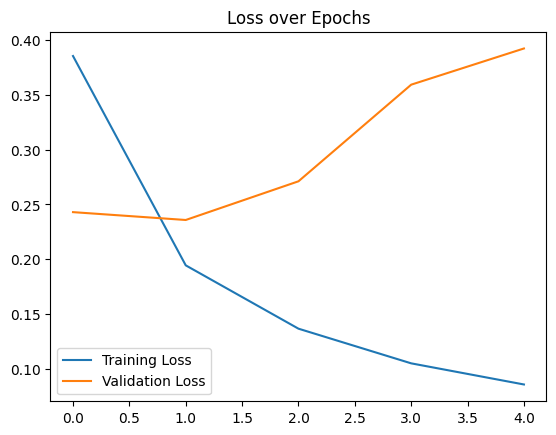

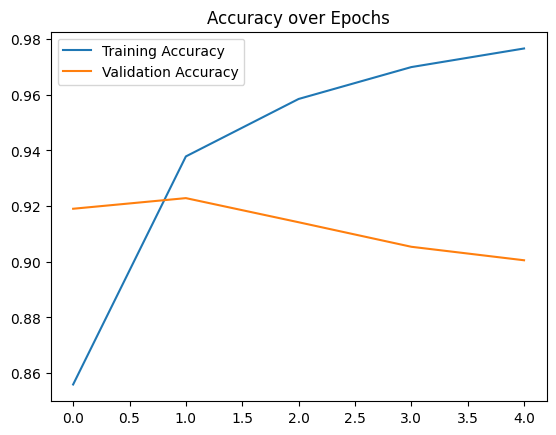

In [ ]:
# Plot training vs validation loss
plt.plot(M.history['loss'], label='Training Loss')
plt.plot(M.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

# Plot training vs validation accuracy
plt.plot(M.history['accuracy'], label='Training Accuracy')
plt.plot(M.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [ ]:
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [ ]:
pred[:5]

array([1, 1, 0, 1, 2])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3812
           1       0.92      0.95      0.93      3807
           2       0.81      0.78      0.79       890

    accuracy                           0.92      8509
   macro avg       0.89      0.88      0.89      8509
weighted avg       0.92      0.92      0.92      8509



Text(0.5, 1.0, 'Confusion Matrix')

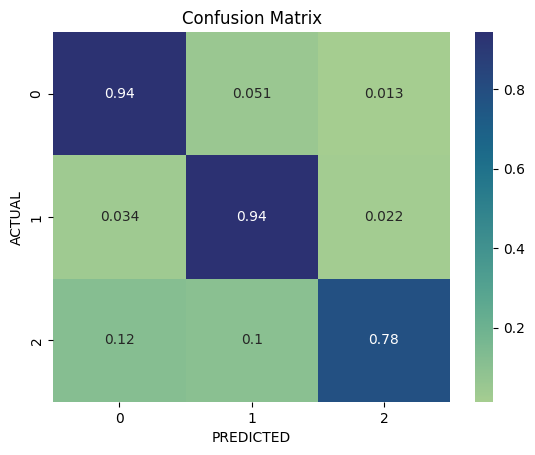

In [ ]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');
plt.title('Confusion Matrix')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # mount once

Mounted at /content/drive


In [ ]:
# Clear the Mount Point First
!fusermount -u /content/drive
!rm -r /content/drive
from google.colab import drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: Invalid argument
Mounted at /content/drive


In [ ]:
# Save trining & test data to Google Drive
np.save('/content/drive/MyDrive/Saved model/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Saved model/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Saved model/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Saved model/y_test.npy', y_test)


In [ ]:
# Save training history
with open('/content/drive/MyDrive/Saved model/history.pkl', 'wb') as f:
    pickle.dump(M.history, f)


In [ ]:
# Save Final Predictions
np.save('/content/drive/MyDrive/Saved model/y_test.npy', y_test)
np.save('/content/drive/MyDrive/Saved model/pred.npy', pred)

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Saved model/my_model.keras')

## Before Load the Model Import all the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # mount again for load the model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the Trained/Saved Model
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Saved model/my_model.keras')

In [ ]:
# Load the saved arrays
X_train = np.load('/content/drive/MyDrive/Saved model/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Saved model/X_test.npy')
y_train = np.load('/content/drive/MyDrive/Saved model/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Saved model/y_test.npy')

In [ ]:
# Check the model accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100:.3f}%')

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9266 - loss: 0.2348
Model Accuracy : 92.314%


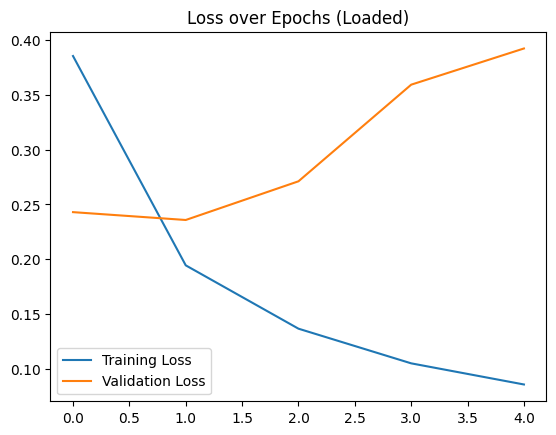

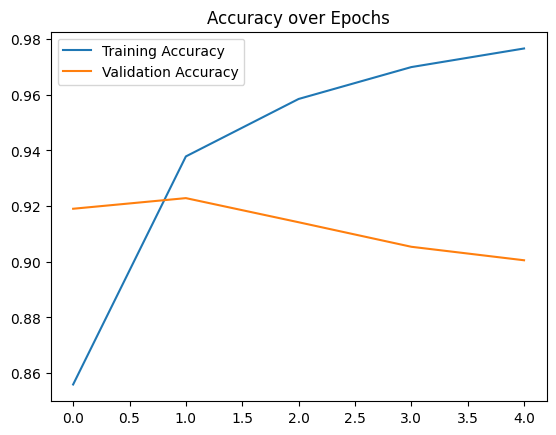

In [ ]:
# Replot from loaded history
with open('/content/drive/MyDrive/Saved model/history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

# Plot training vs validation loss
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs (Loaded)")
plt.show()

# Plot training vs validation accuracy
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [ ]:
# Load Final Predictions
y_test = np.load('/content/drive/MyDrive/Saved model/y_test.npy')
pred = np.load('/content/drive/MyDrive/Saved model/pred.npy')

Text(0.5, 1.0, 'Confusion Matrix')

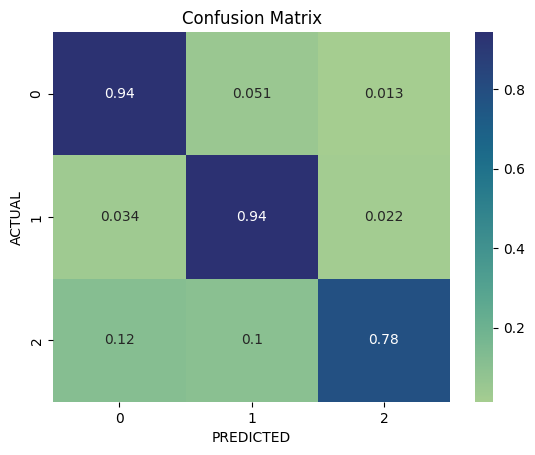

In [ ]:
# Load Confusion Matrix
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');
plt.title('Confusion Matrix')

In [ ]:
model.save("my_model.keras")